# Prototype V2
New Features:
- Online Metrics Calculation

# Overview
- System
  - Two Classes:
    - Events of Interest
      - Following Gaussian Distribution
    - Evemnts of No Interest
      - Following Gaussian Distribution
  - Event Representation
    - A Single Value
- Estimator
  - A classifier to classify the events into two classes
  - Metrics Calculation
    - Estimated Metrics
      - TP，FP，TN，FN
      - Precision
      - Recall
      - Fbeta Score (beta = 2)
    - Ground Truth Metrics
      - TP，FP，TN，FN
      - Precision
      - Recall
      - Fbeta Score (beta = 2)
- Planning
  - If yes, threshold stays the same
  - If no, threshold goes up, scalor factor can be adjusted
- Controller
  - If yes, threshold stays the same
  - If no, threshold goes up, scalor factor can be adjusted
  
# System
## Events Generation
ratio of events of interest: 0.05
ratio of events of no interest: 0.95
### Events of Interest
mean: xx std: xx

### Events of No Interest
mean: xx std: xx
note: take absolute value

## Triggering Mechanism
- above the threshold, trigger the event, log as 1
- below the threshold, do not trigger the event, log as 0

# Estimator
- assume it is 100% accurate, use the ground truth data
- two sliding windows to facilitate the calculation of metrics
- one for estimated TP, FP, TN, FN, then calculate precision, recall, Fbeta score, the results are stored in an array
- one for ground truth TP, FP, TN, FN, then calculate precision, recall, Fbeta score, the results are stored in an array

# Planning
- if the captured event is classified as 1, then the threshold stays the same
- if the captured event is classified as 0, then the threshold goes up

# Controller
- if the captured event is classified as 1, then the threshold stays the same
- if the captured event is classified as 0, then the threshold goes up

In [21]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import os
import csv
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

In [22]:
# Environment Variables
Num_Events = 10000
ratio_interest = 0.05
Num_Events_Interest = int(Num_Events * ratio_interest)
Num_Events_NoInterest = Num_Events - Num_Events_Interest
random_number = 0
random_seed = 2023
random.seed(random_seed)
event_value = 0
event_class = 0

# Events Generation
# Events of No Interest
mean_0 = 10
std_0 = 2
# Events of Interest
mean_1 = 13
std_1 = 2

# History Record
Events = np.zeros((Num_Events, 5)) # time | value | ground truth label (1 interested 0 not ) | capture flag (1 captured 0 not) - by triggering mechanism | classified label (1 interested 0 not) - by estimator

Thresholds = np.zeros((Num_Events, 2)) # time | threshold value 


In [23]:
# Assistive Functions & Variables

# I - System 
# Triggering Mechanism
threshold = 0 # initial value
step_factor = 1/50
change_interval = step_factor*(mean_1 - mean_0)

# II - Estimator
# Estimated Metrics
TP = 0
TN = 0
FP = 0
FN = 0

P = 0
R = 0
Fb = 0

# Ground Truth Metrics
TP_GT = 0
TN_GT = 0
FP_GT = 0
FN_GT = 0

P_GT = 0
R_GT = 0
Fb_GT = 0

# Downstream Metrics

BETA = 2

def Precision(TP, FP):
    if TP + FP == 0:
        return 0
    else:
        return TP / (TP + FP)
def Recall(TP, FN):
    if TP + FN == 0:
        return 0
    else:
        return TP / (TP + FN)
def Fbeta_Score(TP, FP, FN):
    if Precision(TP, FP) == 0 or Recall(TP, FN) == 0:
        return 0
    else:
        return (1 + BETA**2) * Precision(TP, FP) * Recall(TP, FN) / (BETA**2 * Precision(TP, FP) + Recall(TP, FN))

# Sliding Windows
window_size = 300
Window_Est = np.zeros((window_size, 5)) # time | value | ground truth label | capture flag | classified label
Window_GT = np.zeros((window_size, 5)) # time | value | ground truth label | capture flag | classified label

# Arraies to store the metrics
Metrics_Est = np.zeros((Num_Events, 8)) # time | TP | FP | FN | TN | Precision | Recall | Fbeta_Score
Metrics_GT = np.zeros((Num_Events, 8)) # time | TP | FP | FN | TN | Precision | Recall | Fbeta_Score

# III - Planner & Controller
up_factor = 1
down_factor = 1

In [24]:
# SATM Prototype - no NN involved in this version

for i in range (0,Num_Events):
    
    # print progress
    if i % 500 == 0:
        print("Simulation Progress %d/%d" %(i, Num_Events))
    Events[i,0] = i # update time in Events 
    
    # Environment
    random_number = random.random()
    if random_number <= ratio_interest:
        event_class = 1
        Events[i,2] = event_class
        event_value = random.gauss(mean_1, std_1)
        Events[i,1] = event_value
    else:
        event_class = 0
        Events[i,2] = event_class 
        event_value = random.gauss(mean_0, std_0)
        event_value = np.abs(event_value)
        Events[i,1] = event_value
        
    # I - System : Triggering Mechanism - to update the Events[i,3]
    if event_value >= threshold:
        Events[i,3] = 1
    
    # II - Estimator : to update the Events[i,4] - this version we assume the estimator is perfect, so we directly copy the ground truth label
    Events[i,4] = Events[i,2]
    
    # Sliding Windows
    ## Window_Est
    if i < window_size:
        Window_Est = Events[0:window_size,:]
    else:
        Window_Est = Events[i-window_size:i,:]
    
    ## Window_GT
    if i < window_size:
        Window_GT = Events[0:window_size,:]
    else:
        Window_GT = Events[i-window_size:i,:]
    
    # Metrics Calculation
    # reset assistive variables TP, TN, FP, FN, P, R, Fb, TP_GT, TN_GT, FP_GT, FN_GT, P_GT, R_GT, Fb_GT
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    P = 0
    R = 0
    Fb = 0
    
    TP_GT = 0
    TN_GT = 0
    FP_GT = 0
    FN_GT = 0
    
    P_GT = 0
    R_GT = 0
    Fb_GT = 0
    
    ## Metrics_Est
    for j in range (0,window_size):
        # Estimation Label         # Capture Flag
        if Window_Est[j,4] == 1 and Window_Est[j,3] == 1:
            TP = TP + 1
        elif Window_Est[j,4] == 1 and Window_Est[j,3] == 0:
            FN = FN + 1
        elif Window_Est[j,4] == 0 and Window_Est[j,3] == 1:
            FP = FP + 1
        elif Window_Est[j,4] == 0 and Window_Est[j,3] == 0:
            TN = TN + 1
        else:
            print("Error in Metrics_Est")
    P = Precision(TP, FP)
    R = Recall(TP, FN)
    Fb = Fbeta_Score(TP, FP, FN)
    
    # time | TP | FP | FN | TN | Precision | Recall | Fbeta_Score
    Metrics_Est[i,0] = i
    Metrics_Est[i,1] = TP
    Metrics_Est[i,2] = FP
    Metrics_Est[i,3] = FN
    Metrics_Est[i,4] = TN
    Metrics_Est[i,5] = P
    Metrics_Est[i,6] = R
    Metrics_Est[i,7] = Fb
    
    ## Metrics_GT
    for j in range (0,window_size):
        # Ground Truth Label         # Capture Flag
        if Window_GT[j,2] == 1 and Window_GT[j,3] == 1:
            TP_GT = TP_GT + 1
        elif Window_GT[j,2] == 1 and Window_GT[j,3] == 0:
            FN_GT = FN_GT + 1
        elif Window_GT[j,2] == 0 and Window_GT[j,3] == 1:
            FP_GT = FP_GT + 1
        elif Window_GT[j,2] == 0 and Window_GT[j,3] == 0:
            TN_GT = TN_GT + 1
        else:
            print("Error in Metrics_GT")
    P_GT = Precision(TP_GT, FP_GT)
    R_GT = Recall(TP_GT, FN_GT)
    Fb_GT = Fbeta_Score(TP_GT, FP_GT, FN_GT)
    
    # time | TP | FP | FN | TN | Precision | Recall | Fbeta_Score
    Metrics_GT[i,0] = i
    Metrics_GT[i,1] = TP_GT
    Metrics_GT[i,2] = FP_GT
    Metrics_GT[i,3] = FN_GT
    Metrics_GT[i,4] = TN_GT
    Metrics_GT[i,5] = P_GT
    Metrics_GT[i,6] = R_GT
    Metrics_GT[i,7] = Fb_GT
      
    # III - Planner & Controller : to update the threshold
    if Events[i,3] == 1 and Events[i,4] == 0: # in fact not interested but captured
        threshold = threshold + up_factor*change_interval
    elif Events[i,3] == 0 and Events[i,4] == 1: # in fact interested but missed
        threshold = threshold - down_factor*change_interval
    else: # other cases: no change
        threshold = threshold
    
    # update threshold history   
    Thresholds[i,0] = i
    Thresholds[i,1] = threshold
    

Simulation Progress 0/10000
Simulation Progress 500/10000
Simulation Progress 1000/10000
Simulation Progress 1500/10000
Simulation Progress 2000/10000
Simulation Progress 2500/10000
Simulation Progress 3000/10000
Simulation Progress 3500/10000
Simulation Progress 4000/10000
Simulation Progress 4500/10000
Simulation Progress 5000/10000
Simulation Progress 5500/10000
Simulation Progress 6000/10000
Simulation Progress 6500/10000
Simulation Progress 7000/10000
Simulation Progress 7500/10000
Simulation Progress 8000/10000
Simulation Progress 8500/10000
Simulation Progress 9000/10000
Simulation Progress 9500/10000


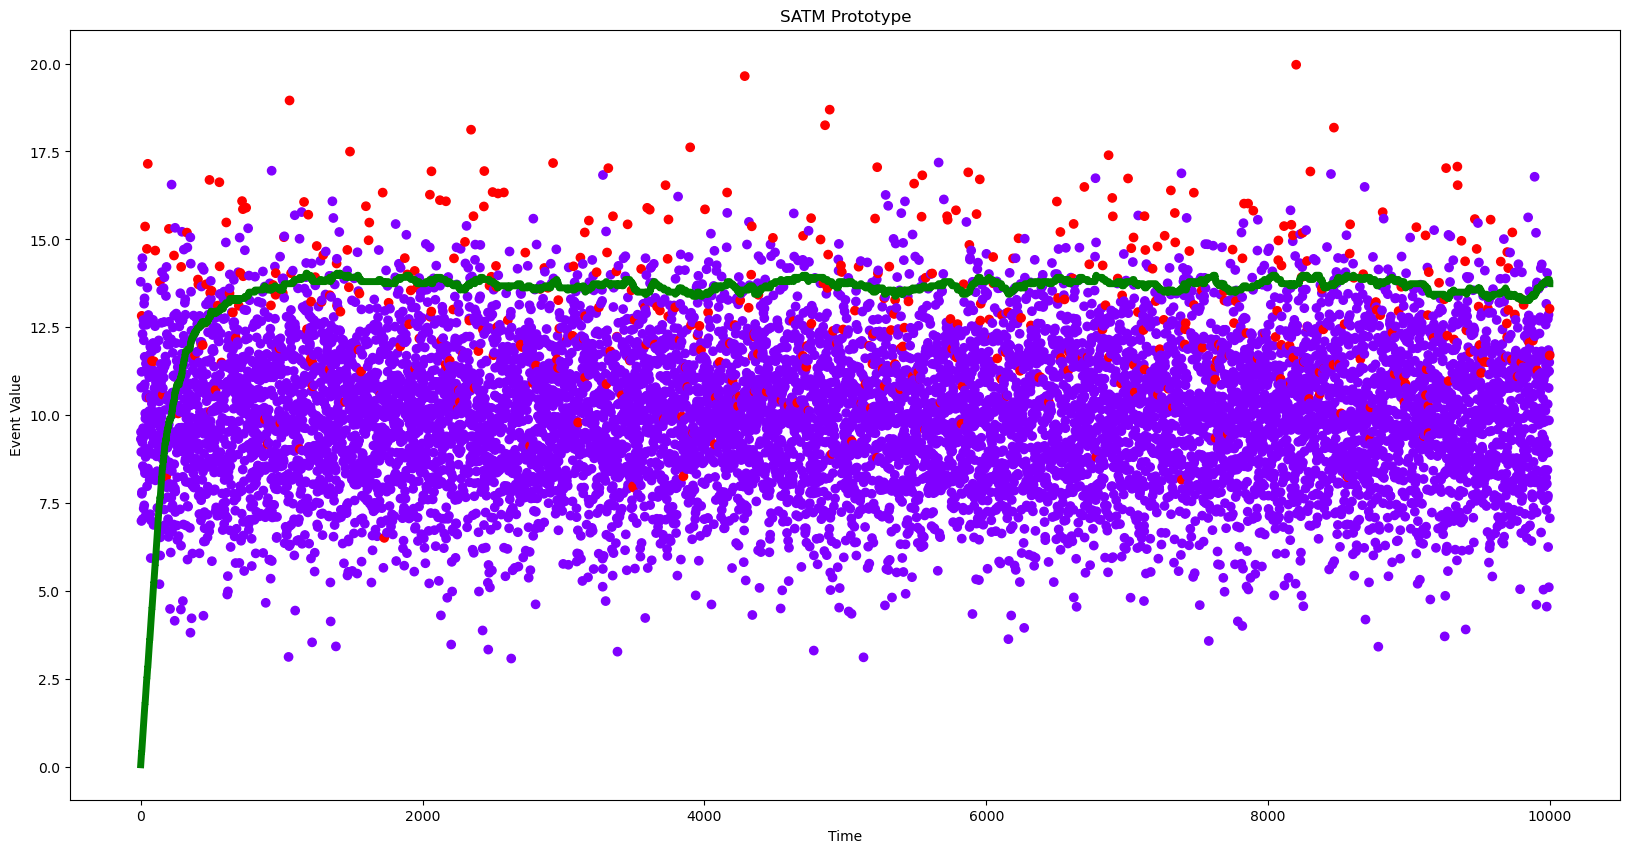

In [25]:
# plot results
plt.figure(figsize=(20,10))
plt.scatter(Events[:,0], Events[:,1], c=Events[:,2], cmap='rainbow')
plt.plot(Thresholds[:,0], Thresholds[:,1], color='green', linewidth=5)

# labels
plt.xlabel('Time')
plt.ylabel('Event Value')

# title
plt.title('SATM Prototype')

# save figure
plt.savefig('SATM_Prototype_V2.png')

# show figure
plt.show()

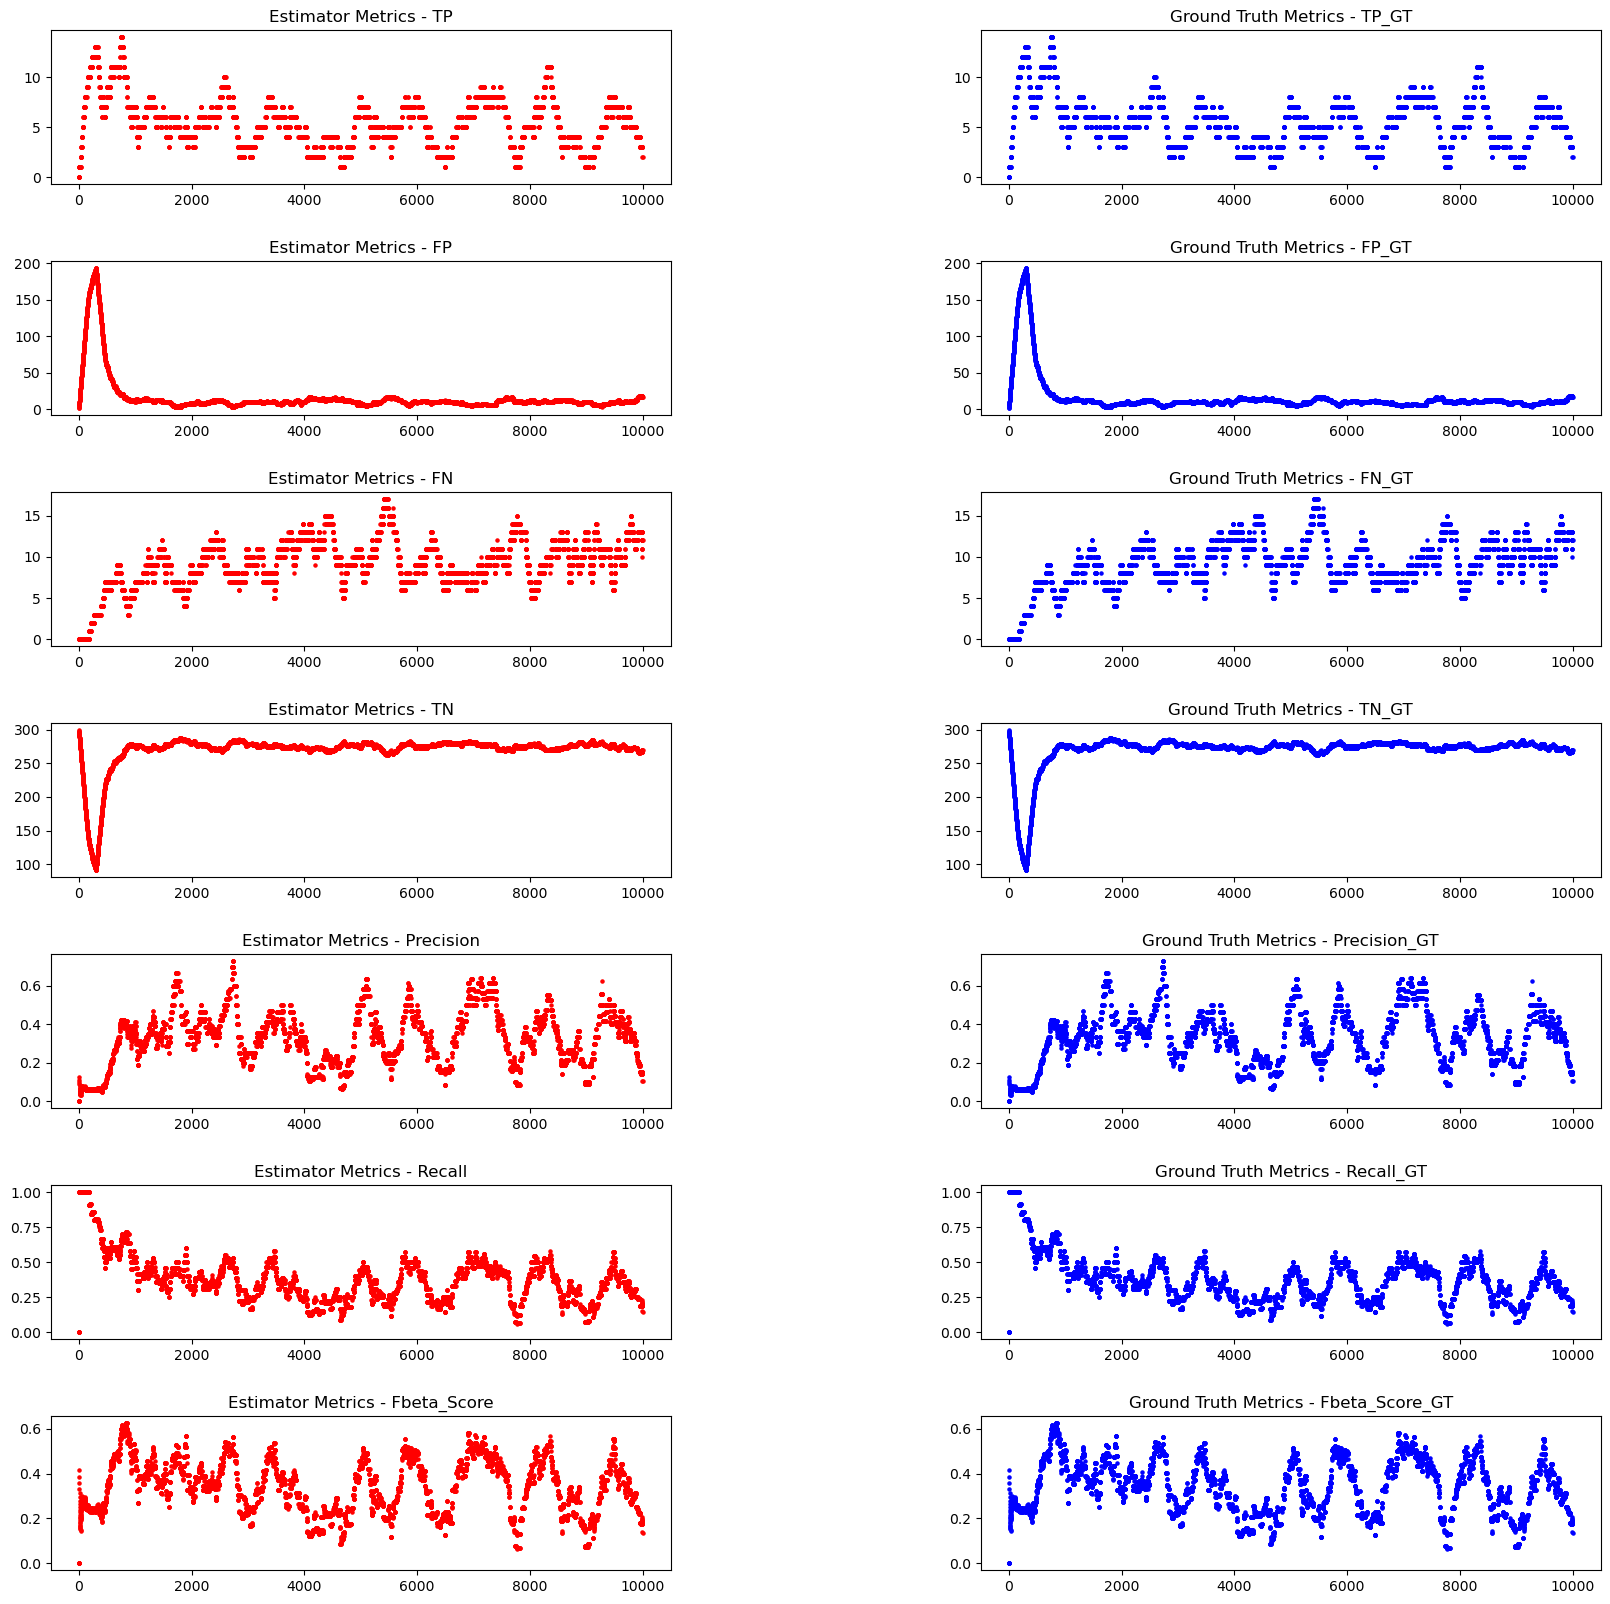

In [26]:
# plot the metrics, use subplots, compare the metrics of Estimator and Ground Truth. the first subplot is TP, the second is FP, the third is FN, the fourth is TN, the fifth is Precision, the sixth is Recall, the seventh is Fbeta_Score. so the total number is 7 rows and 2 columns. column 1 is Estimator, column 2 is Ground Truth.

# # plot results
# plt.figure(figsize=(20,10))

# # Estimator Metrics TP
# plt.subplot(7,2,1)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,1], color='red')
# plt.title('Estimator Metrics - TP')

# # Ground Truth Metrics TP_GT
# plt.subplot(7,2,2)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,1], color='red')
# plt.title('Ground Truth Metrics - TP_GT')

# # Estimator Metrics FP
# plt.subplot(7,2,3)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,2], color='red')
# plt.title('Estimator Metrics - FP')

# # Ground Truth Metrics FP_GT
# plt.subplot(7,2,4)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,2], color='red')
# plt.title('Ground Truth Metrics - FP_GT')

# # Estimator Metrics FN
# plt.subplot(7,2,5)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,3], color='red')
# plt.title('Estimator Metrics - FN')

# # Ground Truth Metrics FN_GT
# plt.subplot(7,2,6)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,3], color='red')
# plt.title('Ground Truth Metrics - FN_GT')

# # Estimator Metrics TN
# plt.subplot(7,2,7)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,4], color='red')
# plt.title('Estimator Metrics - TN')

# # Ground Truth Metrics TN_GT
# plt.subplot(7,2,8)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,4], color='red')
# plt.title('Ground Truth Metrics - TN_GT')

# # Estimator Metrics Precision
# plt.subplot(7,2,9)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,5], color='red')
# plt.title('Estimator Metrics - Precision')

# # Ground Truth Metrics Precision_GT
# plt.subplot(7,2,10)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,5], color='red')
# plt.title('Ground Truth Metrics - Precision_GT')

# # Estimator Metrics Recall
# plt.subplot(7,2,11)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,6], color='red')
# plt.title('Estimator Metrics - Recall')

# # Ground Truth Metrics Recall_GT
# plt.subplot(7,2,12)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,6], color='red')
# plt.title('Ground Truth Metrics - Recall_GT')

# # Estimator Metrics Fbeta_Score
# plt.subplot(7,2,13)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,7], color='red')
# plt.title('Estimator Metrics - Fbeta_Score')

# # Ground Truth Metrics Fbeta_Score_GT
# plt.subplot(7,2,14)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,7], color='red')
# plt.title('Ground Truth Metrics - Fbeta_Score_GT')

# # save figure
# plt.savefig('SATM_Prototype_Metrics.png')

# # show figure
# plt.show()

# Create subplots
fig, axs = plt.subplots(7, 2, figsize=(20, 20))

# Adjust the space between subplots
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot
# Estimator Metrics TP
axs[0, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,1], color='red', s = 5)
axs[0, 0].set_title('Estimator Metrics - TP')

# Ground Truth Metrics TP_GT
axs[0, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,1], color='blue', s = 5)
axs[0, 1].set_title('Ground Truth Metrics - TP_GT')

# Estimator Metrics FP
axs[1, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,2], color='red', s = 5)
axs[1, 0].set_title('Estimator Metrics - FP')

# Ground Truth Metrics FP_GT
axs[1, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,2], color='blue', s = 5)
axs[1, 1].set_title('Ground Truth Metrics - FP_GT')

# Estimator Metrics FN
axs[2, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,3], color='red', s = 5)
axs[2, 0].set_title('Estimator Metrics - FN')

# Ground Truth Metrics FN_GT
axs[2, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,3], color='blue', s = 5)
axs[2, 1].set_title('Ground Truth Metrics - FN_GT')

# Estimator Metrics TN
axs[3, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,4], color='red', s = 5)
axs[3, 0].set_title('Estimator Metrics - TN')

# Ground Truth Metrics TN_GT
axs[3, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,4], color='blue', s = 5)
axs[3, 1].set_title('Ground Truth Metrics - TN_GT')

# Estimator Metrics Precision
axs[4, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,5], color='red', s = 5)
axs[4, 0].set_title('Estimator Metrics - Precision')

# Ground Truth Metrics Precision_GT
axs[4, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,5], color='blue', s = 5)
axs[4, 1].set_title('Ground Truth Metrics - Precision_GT')

# Estimator Metrics Recall
axs[5, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,6], color='red', s = 5)
axs[5, 0].set_title('Estimator Metrics - Recall')

# Ground Truth Metrics Recall_GT
axs[5, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,6], color='blue', s = 5)
axs[5, 1].set_title('Ground Truth Metrics - Recall_GT')

# Estimator Metrics Fbeta_Score
axs[6, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,7], color='red', s = 5)
axs[6, 0].set_title('Estimator Metrics - Fbeta_Score')

# Ground Truth Metrics Fbeta_Score_GT
axs[6, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,7], color='blue', s = 5)
axs[6, 1].set_title('Ground Truth Metrics - Fbeta_Score_GT')

# save figure
plt.savefig('SATM_Prototype_Metrics_V2.png')





Text(0.5, 1.0, 'Ground Truth Metrics - TP_GT')

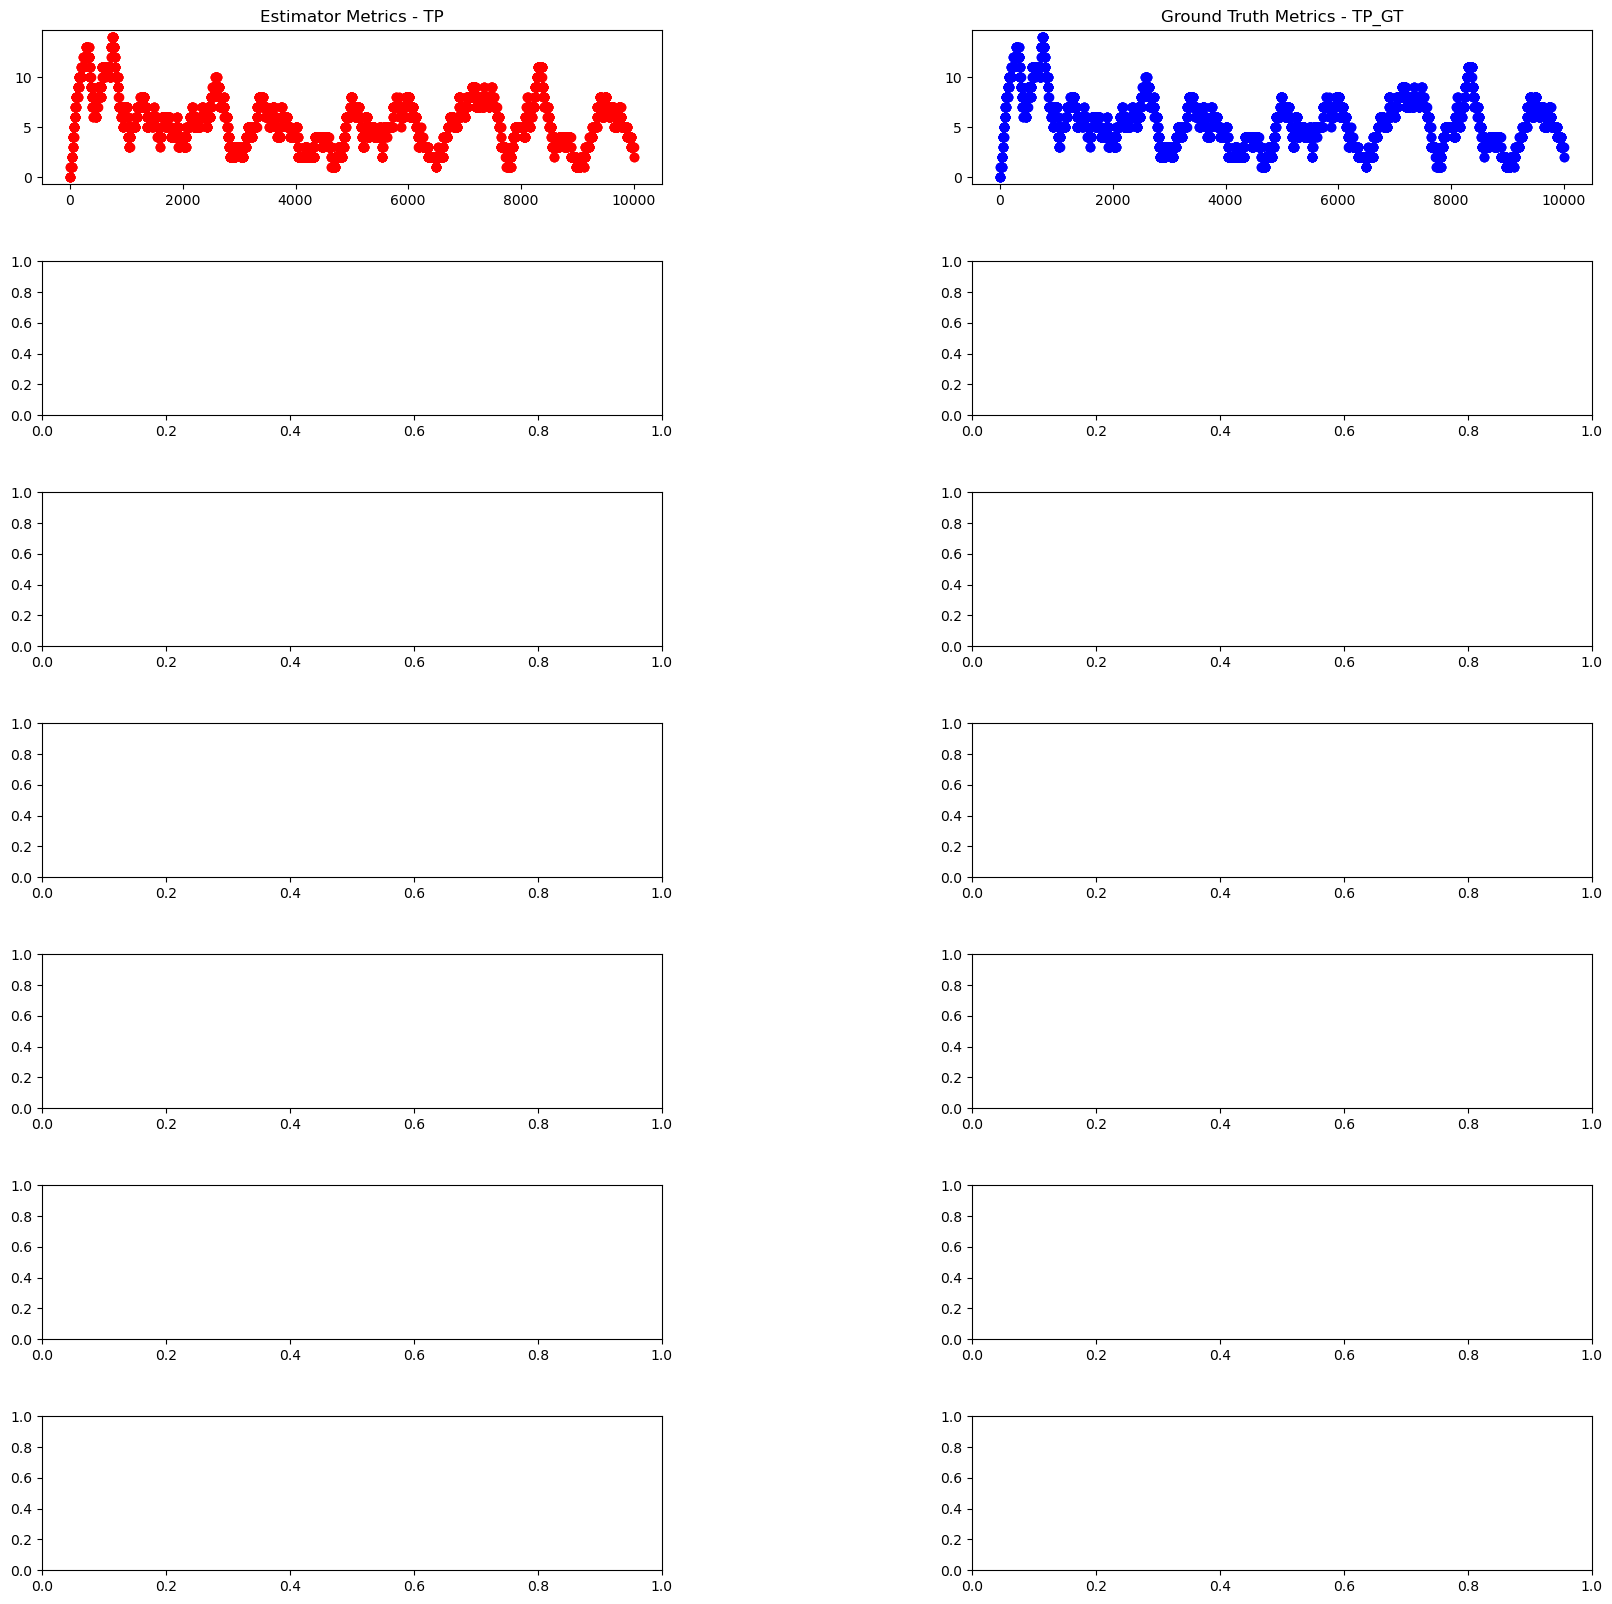

In [27]:
# plot the metrics, use subplots, compare the metrics of Estimator and Ground Truth. the first subplot is TP, the second is FP, the third is FN, the fourth is TN, the fifth is Precision, the sixth is Recall, the seventh is Fbeta_Score. so the total number is 7 rows and 2 columns. column 1 is Estimator, column 2 is Ground Truth.

# # plot results
# plt.figure(figsize=(20,10))

# # Estimator Metrics TP
# plt.subplot(7,2,1)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,1], color='red')
# plt.title('Estimator Metrics - TP')

# # Ground Truth Metrics TP_GT
# plt.subplot(7,2,2)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,1], color='red')
# plt.title('Ground Truth Metrics - TP_GT')

# # Estimator Metrics FP
# plt.subplot(7,2,3)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,2], color='red')
# plt.title('Estimator Metrics - FP')

# # Ground Truth Metrics FP_GT
# plt.subplot(7,2,4)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,2], color='red')
# plt.title('Ground Truth Metrics - FP_GT')

# # Estimator Metrics FN
# plt.subplot(7,2,5)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,3], color='red')
# plt.title('Estimator Metrics - FN')

# # Ground Truth Metrics FN_GT
# plt.subplot(7,2,6)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,3], color='red')
# plt.title('Ground Truth Metrics - FN_GT')

# # Estimator Metrics TN
# plt.subplot(7,2,7)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,4], color='red')
# plt.title('Estimator Metrics - TN')

# # Ground Truth Metrics TN_GT
# plt.subplot(7,2,8)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,4], color='red')
# plt.title('Ground Truth Metrics - TN_GT')

# # Estimator Metrics Precision
# plt.subplot(7,2,9)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,5], color='red')
# plt.title('Estimator Metrics - Precision')

# # Ground Truth Metrics Precision_GT
# plt.subplot(7,2,10)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,5], color='red')
# plt.title('Ground Truth Metrics - Precision_GT')

# # Estimator Metrics Recall
# plt.subplot(7,2,11)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,6], color='red')
# plt.title('Estimator Metrics - Recall')

# # Ground Truth Metrics Recall_GT
# plt.subplot(7,2,12)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,6], color='red')
# plt.title('Ground Truth Metrics - Recall_GT')

# # Estimator Metrics Fbeta_Score
# plt.subplot(7,2,13)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,7], color='red')
# plt.title('Estimator Metrics - Fbeta_Score')

# # Ground Truth Metrics Fbeta_Score_GT
# plt.subplot(7,2,14)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,7], color='red')
# plt.title('Ground Truth Metrics - Fbeta_Score_GT')

# # save figure
# plt.savefig('SATM_Prototype_Metrics.png')

# # show figure
# plt.show()

# Create subplots
fig, axs = plt.subplots(7, 2, figsize=(20, 20))

# Adjust the space between subplots
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot

# Estimator Metrics TP
axs[0, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,1], color='red', linewidth=1)
axs[0, 0].set_title('Estimator Metrics - TP')

# Ground Truth Metrics TP_GT
axs[0, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,1], color='blue', linewidth=1)
axs[0, 1].set_title('Ground Truth Metrics - TP_GT')



Text(0.5, 1.0, 'Ground Truth Metrics - TP_GT')

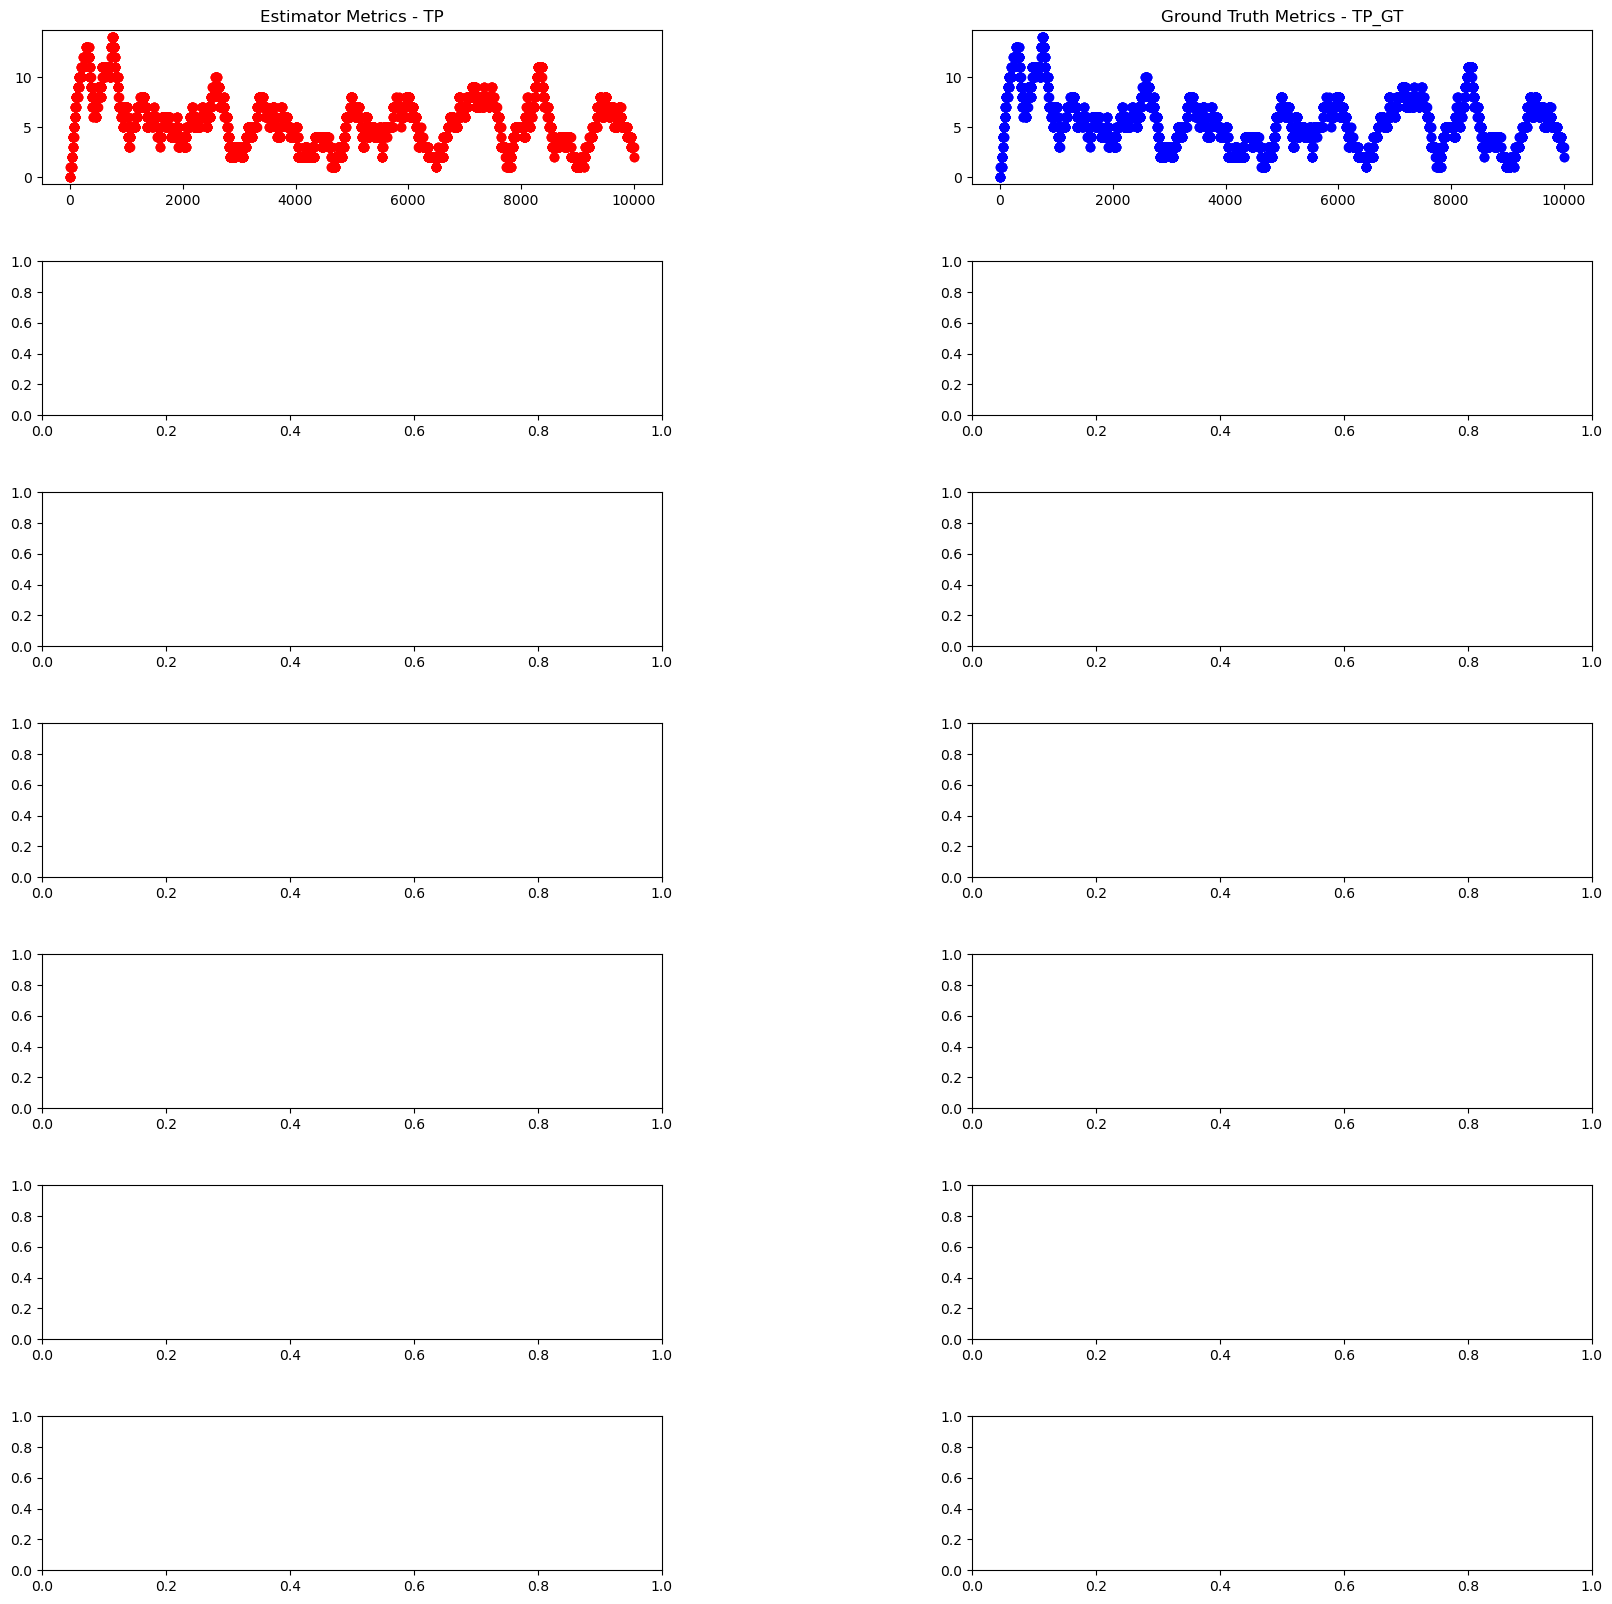

In [28]:
# plot the metrics, use subplots, compare the metrics of Estimator and Ground Truth. the first subplot is TP, the second is FP, the third is FN, the fourth is TN, the fifth is Precision, the sixth is Recall, the seventh is Fbeta_Score. so the total number is 7 rows and 2 columns. column 1 is Estimator, column 2 is Ground Truth.

# # plot results
# plt.figure(figsize=(20,10))

# # Estimator Metrics TP
# plt.subplot(7,2,1)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,1], color='red')
# plt.title('Estimator Metrics - TP')

# # Ground Truth Metrics TP_GT
# plt.subplot(7,2,2)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,1], color='red')
# plt.title('Ground Truth Metrics - TP_GT')

# # Estimator Metrics FP
# plt.subplot(7,2,3)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,2], color='red')
# plt.title('Estimator Metrics - FP')

# # Ground Truth Metrics FP_GT
# plt.subplot(7,2,4)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,2], color='red')
# plt.title('Ground Truth Metrics - FP_GT')

# # Estimator Metrics FN
# plt.subplot(7,2,5)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,3], color='red')
# plt.title('Estimator Metrics - FN')

# # Ground Truth Metrics FN_GT
# plt.subplot(7,2,6)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,3], color='red')
# plt.title('Ground Truth Metrics - FN_GT')

# # Estimator Metrics TN
# plt.subplot(7,2,7)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,4], color='red')
# plt.title('Estimator Metrics - TN')

# # Ground Truth Metrics TN_GT
# plt.subplot(7,2,8)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,4], color='red')
# plt.title('Ground Truth Metrics - TN_GT')

# # Estimator Metrics Precision
# plt.subplot(7,2,9)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,5], color='red')
# plt.title('Estimator Metrics - Precision')

# # Ground Truth Metrics Precision_GT
# plt.subplot(7,2,10)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,5], color='red')
# plt.title('Ground Truth Metrics - Precision_GT')

# # Estimator Metrics Recall
# plt.subplot(7,2,11)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,6], color='red')
# plt.title('Estimator Metrics - Recall')

# # Ground Truth Metrics Recall_GT
# plt.subplot(7,2,12)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,6], color='red')
# plt.title('Ground Truth Metrics - Recall_GT')

# # Estimator Metrics Fbeta_Score
# plt.subplot(7,2,13)
# plt.scatter(Metrics_Est[:,0], Metrics_Est[:,7], color='red')
# plt.title('Estimator Metrics - Fbeta_Score')

# # Ground Truth Metrics Fbeta_Score_GT
# plt.subplot(7,2,14)
# plt.scatter(Metrics_GT[:,0], Metrics_GT[:,7], color='red')
# plt.title('Ground Truth Metrics - Fbeta_Score_GT')

# # save figure
# plt.savefig('SATM_Prototype_Metrics.png')

# # show figure
# plt.show()

# Create subplots
fig, axs = plt.subplots(7, 2, figsize=(20, 20))

# Adjust the space between subplots
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot

# Estimator Metrics TP
axs[0, 0].scatter(Metrics_Est[:,0], Metrics_Est[:,1], color='red', linewidth=1)
axs[0, 0].set_title('Estimator Metrics - TP')

# Ground Truth Metrics TP_GT
axs[0, 1].scatter(Metrics_GT[:,0], Metrics_GT[:,1], color='blue', linewidth=1)
axs[0, 1].set_title('Ground Truth Metrics - TP_GT')



In [29]:
# # Plotly Version

# # plot the events
# fig = go.Figure(data=go.Scatter(x=Events[:,0], y=Events[:,1], mode='markers', marker=dict(color=Events[:,2], colorscale='rainbow', line_width=1)))

# # plot the threshold
# fig.add_trace(go.Scatter(x=Thresholds[:,0], y=Thresholds[:,1], mode='lines', line=dict(color='green', width=5)))

# # labels
# fig.update_xaxes(title_text='Time')
# fig.update_yaxes(title_text='Event Value')

# # title
# fig.update_layout(title_text='SATM Prototype')

# # save figure
# fig.write_image('SATM_Prototype_Plotly.png')

# # show figure
# fig.show()